<a href="https://colab.research.google.com/github/youshouldcodesomething/node-classification-using-gnn/blob/main/internship_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import torch; print(torch.version.cuda)"


!pip install  torch-scatter -f https://data.org/whl/torch-${TORCH}+${CUDA}.html
!pip install  torch-sparse -f https://data.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

11.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.org/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=274491 sha256=6fb379c17b374d2ae8a1ae597643ab5507da2955ba841416695fe1cc732456e9
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.org/whl/torch-+.html
     |████████████████████████████████| 51 kB 227 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=497879 sha256=20639338d5130fb89c6dde34af646a607500c2f4971be6c2542cdb287fb85617
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully built torch-sparse
Looking

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='pubmed', transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')


data = dataset[0]  

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 500
Number of classes: 3
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Number of training nodes: 60
Training node label rate: 0.00
Is undirected: True


In [ ]:
print(data.x.shape)


data.x[0][:50]


torch.Size([19717, 500])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0031, 0.0000,
        0.0000, 0.0000, 0.0302, 0.0000, 0.0082, 0.0108, 0.0000, 0.0110, 0.0000,
        0.0064, 0.0164, 0.0000, 0.0000, 0.0080, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0131, 0.0000, 0.0000, 0.0097, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0136, 0.0107, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0122])

In [ ]:
data.y

tensor([1, 1, 0,  ..., 2, 0, 2])

In [ ]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [ ]:
data.edge_index.t()

tensor([[    0,  1378],
        [    0,  1544],
        [    0,  6092],
        ...,
        [19714, 12278],
        [19715,  4284],
        [19716, 16030]])

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=3, bias=True)
)


In [ ]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.0989
Epoch: 100, Loss: 0.8362
Epoch: 200, Loss: 0.6784
Epoch: 300, Loss: 0.6832
Epoch: 400, Loss: 0.6235
Epoch: 500, Loss: 0.6475
Epoch: 600, Loss: 0.6368
Epoch: 700, Loss: 0.6093
Epoch: 800, Loss: 0.6558
Epoch: 900, Loss: 0.6330
Epoch: 1000, Loss: 0.6066


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


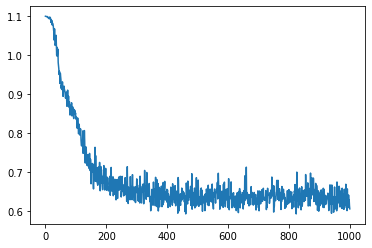

In [ ]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6760


torch.Size([19717, 3])


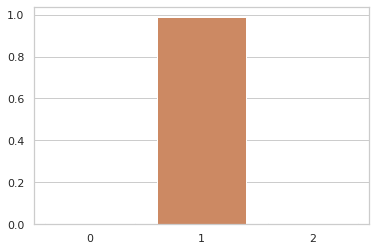

In [ ]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(3)), y=pred[sample].detach().cpu().numpy())